# FOCUS STACKING

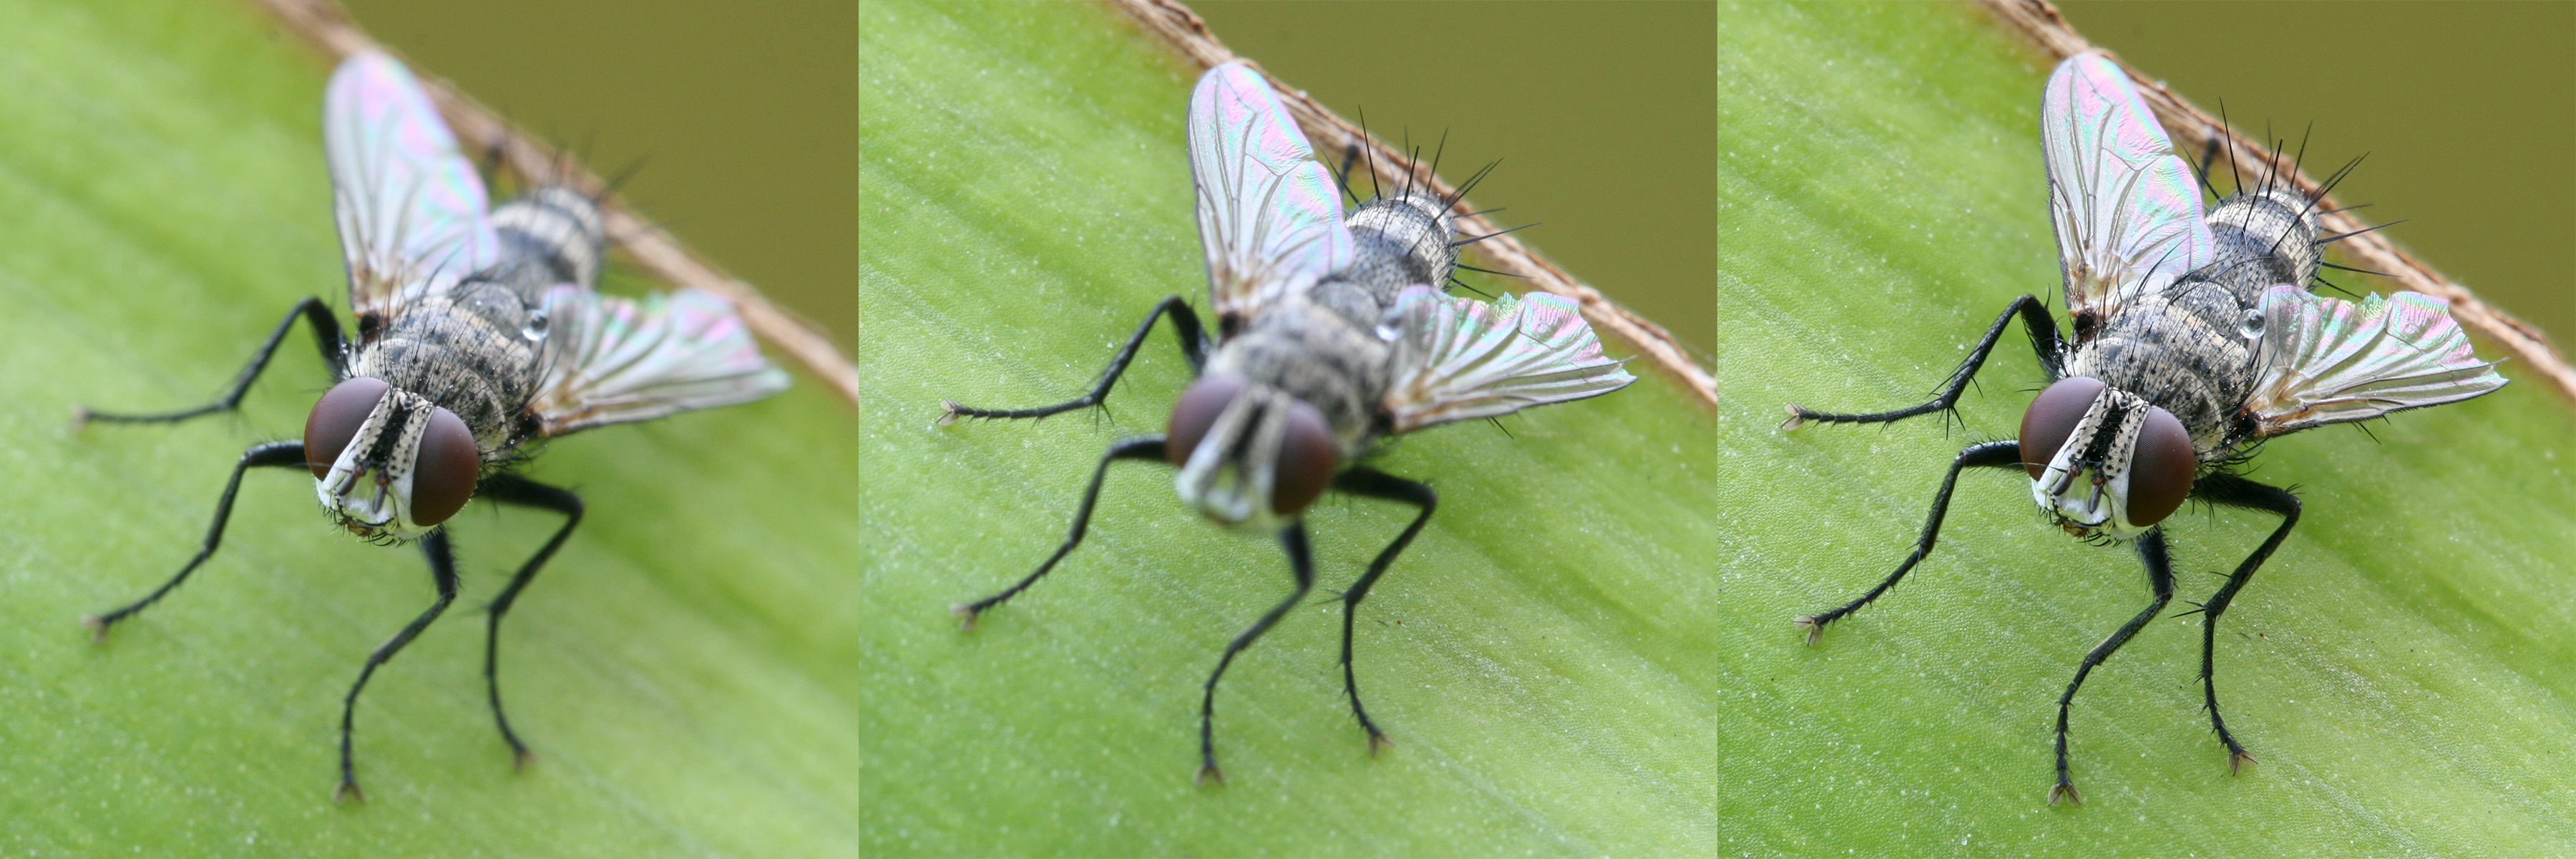

O empilhamento de foco "Focus stacking" é uma técnica que permite aos fotógrafos criar uma única imagem onde objetos em vários planos focais estão todos em foco. O empilhamento de foco, também chamado de empilhamento de fotos ou camadas de foco, pode criar o efeito de uma profundidade de campo mais profunda sem qualquer perda de clareza ou nitidez. A técnica envolve fotografar a mesma composição várias vezes com vários pontos focais. Essas imagens são então compostas no Photoshop ou outro software de edição para criar uma única imagem na qual tudo na foto está em foco. O empilhamento de foco é frequentemente usado em fotografia de paisagem, fotografia de produto e fotografia macro, onde vários elementos em planos focais variáveis precisam estar em foco.

In [ ]:
!git clone https://github.com/cmcguinness/focusstack.git

### Importar as bibliotecas

In [ ]:
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt

### Aplicar homografia para retificação

In [ ]:
def findHomography(image_1_kp, image_2_kp, matches):
    image_1_points = np.zeros((len(matches), 1, 2), dtype=np.float32)
    image_2_points = np.zeros((len(matches), 1, 2), dtype=np.float32)

    for i in range(0,len(matches)):
        image_1_points[i] = image_1_kp[matches[i].queryIdx].pt
        image_2_points[i] = image_2_kp[matches[i].trainIdx].pt


    homography, mask = cv2.findHomography(image_1_points, image_2_points, cv2.RANSAC, ransacReprojThreshold=2.0)

    return homography

## Alinhe as imagens.

Mudar o foco de uma lente, mesmo que a câmera permaneça fixa, causa um leve zoom nas imagens. Precisamos corrigir as imagens para que fiquem perfeitamente alinhadas umas sobre as outras.

In [ ]:
def align_images(images):

    # O SIFT geralmente produz melhores resultados, mas não é FOSS, então escolha
    # o detector de recursos que atenda às necessidades requeridas. ORB está OK

    use_sift = True

    outimages = []

    if use_sift:
        detector = cv2.xfeatures2d.SIFT_create()
    else:
        detector = cv2.ORB_create(1000)

    # Assumimos que a imagem 0 é a imagem "base" e alinhamos tudo a ela
    print("Detectando recursos da imagem base")
    outimages.append(images[0])
    image1gray = cv2.cvtColor(images[0],cv2.COLOR_BGR2GRAY)
    image_1_kp, image_1_desc = detector.detectAndCompute(image1gray, None)

    for i in range(1,len(images)):
        print ("Alinhando a imagem {}".format(i))
        image_i_kp, image_i_desc = detector.detectAndCompute(images[i], None)

        if use_sift:
            bf = cv2.BFMatcher()
            # Isso retorna as duas primeiras correspondências para
            # cada ponto de recurso (lista de lista)
            pairMatches = bf.knnMatch(image_i_desc,image_1_desc, k=2)
            rawMatches = []
            for m,n in pairMatches:
                if m.distance < 0.7*n.distance:
                    rawMatches.append(m)
        else:
            bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
            rawMatches = bf.match(image_i_desc, image_1_desc)

        sortMatches = sorted(rawMatches, key=lambda x: x.distance)
        matches = sortMatches[0:128]



        hom = findHomography(image_i_kp, image_1_kp, matches)
        newimage = cv2.warpPerspective(images[i], hom, (images[i].shape[1],
                                                        images[i].shape[0]),
                                                        flags=cv2.INTER_LINEAR)

        outimages.append(newimage)
        # Se você achar que há uma grande quantidade de 'ghosting', pode ser
        # porque uma ou mais das imagens de entrada estão desalinhadas.
        # A saída das imagens alinhadas pode ajudar a diagnosticar isso.
        # cv2.imwrite("aligned{}.png".format(i), newimage)

    return outimages

### Calcular o mapa de gradiente da imagem



*   Tamanho da janela laplaciana: kernerl_size
*   Qual o tamanho do kernel a ser usado para o desfoque gaussiano: blur_size

Geralmente, manter esses dois valores iguais ou muito próximos funciona bem e além disso, usar números ímpares.



In [ ]:
def doLap(image):

    # Pode se ajustar esses valores como for preciso
    kernel_size = 5
    blur_size = 5

    blurred = cv2.GaussianBlur(image, (blur_size,blur_size), 0)
    return cv2.Laplacian(blurred, cv2.CV_64F, ksize=kernel_size)


###   Focus stack:
Esta rotina encontra os pontos de melhor foco em todas as imagens e produz um resultado mesclado.

In [ ]:
def focus_stack(unimages):
    images = align_images(unimages)

    print("Calculando o laplaciano das imagens borradas")
    laps = []
    for i in range(len(images)):
        print("Iteração {}".format(i))
        laps.append(doLap(cv2.cvtColor(images[i],cv2.COLOR_BGR2GRAY)))

    laps = np.asarray(laps)
    print("Forma da matriz de laplacianos = {}".format(laps.shape))

    output = np.zeros(shape=images[0].shape, dtype=images[0].dtype)

    abs_laps = np.absolute(laps)
    maxima = abs_laps.max(axis=0)
    bool_mask = abs_laps == maxima
    mask = bool_mask.astype(np.uint8)
    for i in range(0,len(images)):
        output = cv2.bitwise_not(images[i],output, mask=mask[i])

    return 255-output

In [ ]:
def open_rgb_img(img_src):
  im_cv = cv2.imread(img_src, cv2.IMREAD_UNCHANGED)
  return cv2.cvtColor(im_cv, cv2.COLOR_BGR2RGB)

def read_images(image_files):
    focusimages = []
    for img in image_files:
        print("Lendo arquivo: {}".format(img))
        focusimages.append(open_rgb_img("focusstack/Input/{}".format(img)))
    return focusimages


In [ ]:
def plot_images(images, rows, cols):
  fig = plt.figure(figsize=(12, 6))
  for idx, image in enumerate(images):
      # img = np.random.randint(10, size=(h,w))
      ax = []
      ax.append(fig.add_subplot(rows, cols, idx+1))
      ax[-1].set_title("Image "+str(idx))
      plt.imshow(image)
  plt.show()

Lendo arquivo: step0.jpg
Lendo arquivo: step1.jpg
Lendo arquivo: step2.jpg
Lendo arquivo: step3.jpg
Lendo arquivo: step4.jpg
Lendo arquivo: step5.jpg


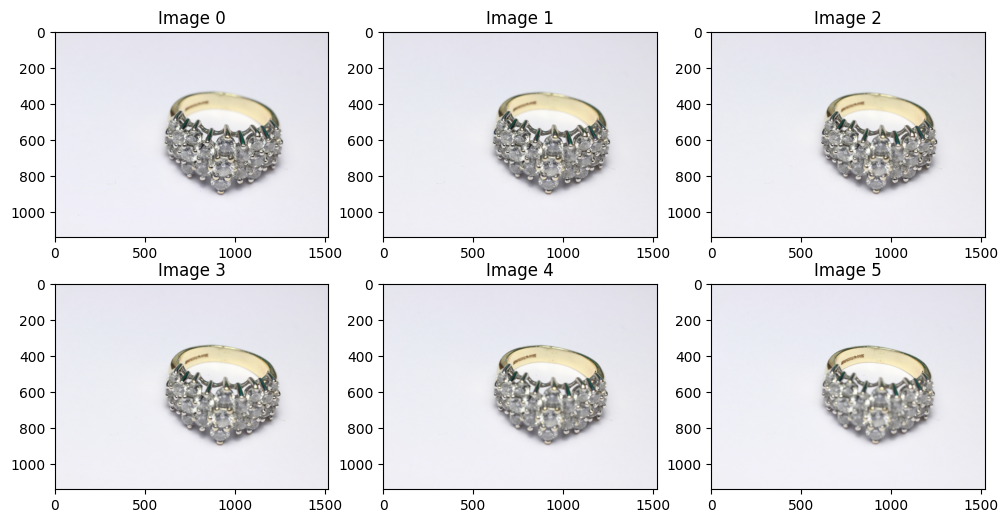

In [11]:
image_files = sorted(os.listdir("focusstack/Input"))
for img in image_files:
    if img.split(".")[-1].lower() not in ["jpg", "jpeg", "png"]:
        image_files.remove(img)

all_images = read_images(image_files)
plot_images(all_images, 2, 3)

Detectando recursos da imagem base
Alinhando a imagem 1
Alinhando a imagem 2
Alinhando a imagem 3
Alinhando a imagem 4
Alinhando a imagem 5
Calculando o laplaciano das imagens borradas
Iteração 0
Iteração 1
Iteração 2
Iteração 3
Iteração 4
Iteração 5
Forma da matriz de laplacianos = (6, 1141, 1521)


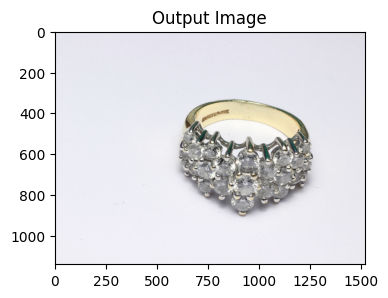

In [12]:
merged = focus_stack(all_images)
cv2.imwrite("merged.png", merged)

#Plot all the images
fig = plt.figure(figsize=(4,4))
columns = 1
rows = 1

ax = []
ax.append(fig.add_subplot(rows, columns, 1))
ax[-1].set_title("Output Image")
plt.imshow(merged)

plt.show()